In [1]:
import scipy
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import math 
import modred as mr
from scipy.linalg import eig
import pysindy as ps
from scipy.signal import savgol_filter
from scipy.io import loadmat
#scipy.__version__

/Users/cassiooishi/miniforge3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# simulation data
in_filename = "16_roll7vtk_Re1_Wi3.5_beta0.9.npz" 

fields = np.load(in_filename, allow_pickle=True)["fields"].item()

# components of the square-root tensor B
Bxx = fields["Bxx"]
Bxy = fields["Bxy"]
Byy = fields["Byy"]

q = np.stack((Bxx, Bxy, Byy), axis=-1)


In [3]:
# constructiong the data matrix from the state vector
T11 = q[:,:,:,0].reshape((q.shape[0]**2, q.shape[2]))
T12 = q[:,:,:,1].reshape((q.shape[0]**2, q.shape[2]))
T22 = q[:,:,:,2].reshape((q.shape[0]**2, q.shape[2]))
T = np.concatenate((T11,T12,T22), axis=1).reshape(-1, q.shape[2]) 
T = T[:,2000:7500]
Tn = T


In [4]:
# subtracting off the mean in time
T_mean = T.mean(1).reshape(-1,1)
Tr = T_mean.reshape((q.shape[0], q.shape[1],3)) 
Tn = T  -  T_mean
Tn2 = Tn.T@Tn

In [5]:
# snapshots method: matrix Q is constructed to be used in SINDy
e,Q = np.linalg.eig(Tn2)
e = np.real(e) 
Q = np.real(Q) 
e[e<0] = 0 


In [6]:
# ORDERING eigenvalues/eigenvectors
idx = np.argsort(-e) 
e = e[idx] 
Q = Q[:,idx] 
E = np.diag(1/np.sqrt(e)) 
Sigma = np.diag(np.sqrt(e)) 


/var/folders/2z/3cfggdrs7xl2wpmkpt9r1wgm0000gn/T/ipykernel_74959/355794776.py:5: RuntimeWarning: divide by zero encountered in divide
  E = np.diag(1/np.sqrt(e))


In [7]:
# preparing data from Q to seed SINDy
c = np.arange(Q.shape[1]).reshape(-1,1)
QQ = np.concatenate((c,Q),1)
np.save("16_roll_Wi_3.5.npy",QQ)    
Avh = np.load("16_roll_Wi_3.5.npy")
t = Avh[:, 0]
Avh = Avh[:,1:]


In [8]:
active_idx = [0, 1]  # Dynamically active modes
# first two POD modes
r = 2
tfrac = 0.8  # Proportion of the data to train on
M = len(t)
M_train = int(len(t) * tfrac)
t_train = t[:M_train]
t_test = t[M_train:]

pod_names = ["a{}".format(i) for i in (active_idx)]

# Normalize the trajectories for simplicity
normalization = sum(np.amax(abs(Avh), axis=0)[active_idx])
x = np.zeros((Avh.shape[0], r))
    
x[:, 0] = Avh[:, 0] / normalization
x[:, 1] = Avh[:, 1] / normalization

# Build an initial guess
initial_guess = np.zeros((r,6))  # manual

x_train = x[:M_train, :]
x0_train = x[0, :]
x_test = x[M_train:, :]
x0_test = x[M_train, :]

In [9]:
# We select linear and cubic terms for the candidate library in SINDy
library_functions = [lambda x:x, 
                             lambda x, y, z: x * y * z, lambda x, y: x ** 2 * y,
                             lambda x, y: x * y ** 2, lambda x: x ** 3]
library_function_names = [lambda x:x, 
                                  lambda x, y, z: x + y + z, lambda x, y: x + x + y,
                                  lambda x, y: x + y + y, lambda x: x + x + x]

sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)




 #SR3 optimizer with an initial guess
sindy_opt = ps.SR3(
    threshold=0.0001, nu=1, max_iter=1000)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)

# Fit a model on the training data
model.fit(x_train, t=t_train)
model.print()
Xi = model.coefficients()


(a0)' = 0.007 a0 + 0.027 a1 + -0.026 a0a0a1 + 0.023 a0a1a1 + -0.045 a0a0a0 + 0.016 a1a1a1
(a1)' = -0.027 a0 + 0.007 a1 + 0.024 a0a0a1 + 0.026 a0a1a1 + -0.016 a0a0a0 + -0.044 a1a1a1


In [10]:
# Get Xdot from the measurement data X
x_dot = model.differentiate(x, t=t)

# Predict Xdot on the training and testing data. 
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)


In [11]:
# prediction for the modes
t_test_full = np.arange(0,5500,1)
init_time = 0

x_sim = model.simulate(x[init_time,:], t_test_full[init_time:])


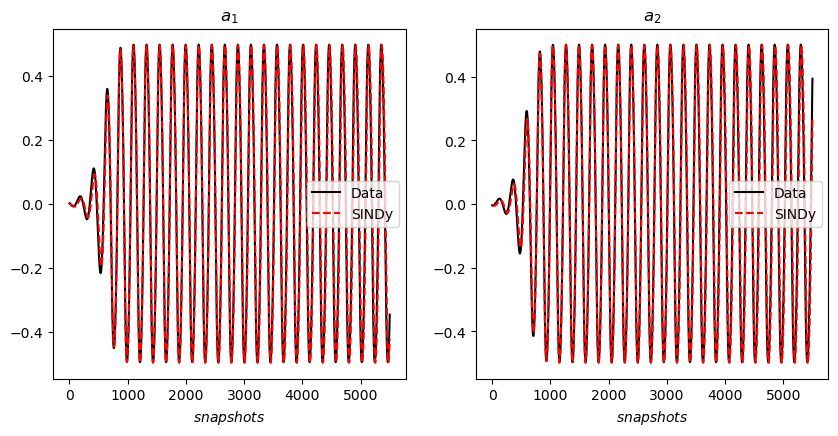

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221)
plt.plot(x[init_time:,0],'black',label="Data")
plt.plot(x_sim[:,0], 'r--', label="SINDy")
plt.xlabel('${snapshots}$')
plt.title('$a_1$')
plt.legend()

ax = fig.add_subplot(222)
plt.plot(x[init_time:,1],'black',label="Data")
plt.plot(x_sim[:,1], 'r--', label="SINDy")
plt.xlabel('${snapshots}$')
plt.title('$a_2$')
plt.legend()

In [13]:
x_train = x[:, :]
t_train = t[:]



In [14]:
# Using quadratic terms, we construct expressions for the third mode
library_functions = [lambda x, y:x * y, lambda x:x ** 2]#
library_function_names = [lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)
sindy_opt = ps.SR3(
    threshold=0.000001, nu=1, max_iter=1000)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)

# Fit a model on the training data
model.fit(x_train, x_dot = Avh[:, 2] / normalization , t=t_train)

model.print()
model.coefficients()

(a0)' = -3.183 a0a1 + 1.394 a0a0 + -1.392 a1a1


array([[-3.18303109,  1.39438272, -1.3924478 ]])

In [15]:
# Using quadratic terms, we construct expressions for the fourth mode
library_functions = [lambda x, y:x * y, lambda x:x ** 2]#
library_function_names = [lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)
sindy_opt = ps.SR3(
    threshold=0.000001, nu=1, max_iter=1000)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)

# Fit a model on the training data
model.fit(x_train, x_dot = Avh[:, 3] / normalization , t=t_train)

model.print()
model.coefficients()

(a0)' = 2.076 a0a1 + 1.581 a0a0 + -1.578 a1a1


array([[ 2.07622825,  1.58074888, -1.57777373]])

In [16]:
def f(a0,a1,coeff):

    a2 = a0*a1*(-3.183) + a0*a0*(1.394) + a1*a1*(-1.392)    
    return a2

def f2(a0,a1,coeff):
    
    a3 = a0*a1*(2.076) + a0*a0*(1.581) + a1*a1*(-1.578)
    
    return a3


In [17]:
# organizing data for predictions of the four first modes
a0 = x[:,0]
a1 = x[:,1]
a2 = f(a0,a1,model.coefficients)
a3 = f2(a0,a1,model.coefficients)


In [18]:
def rescale_ticks(axis, fat, shift):
    tcks = axis.get_xticks()
    tcks_label = shift + tcks*fat
    
    axis.set_xticklabels([f'{i:g}' for i in tcks_label])


/var/folders/2z/3cfggdrs7xl2wpmkpt9r1wgm0000gn/T/ipykernel_74959/2340168236.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([f'{i:g}' for i in tcks_label])


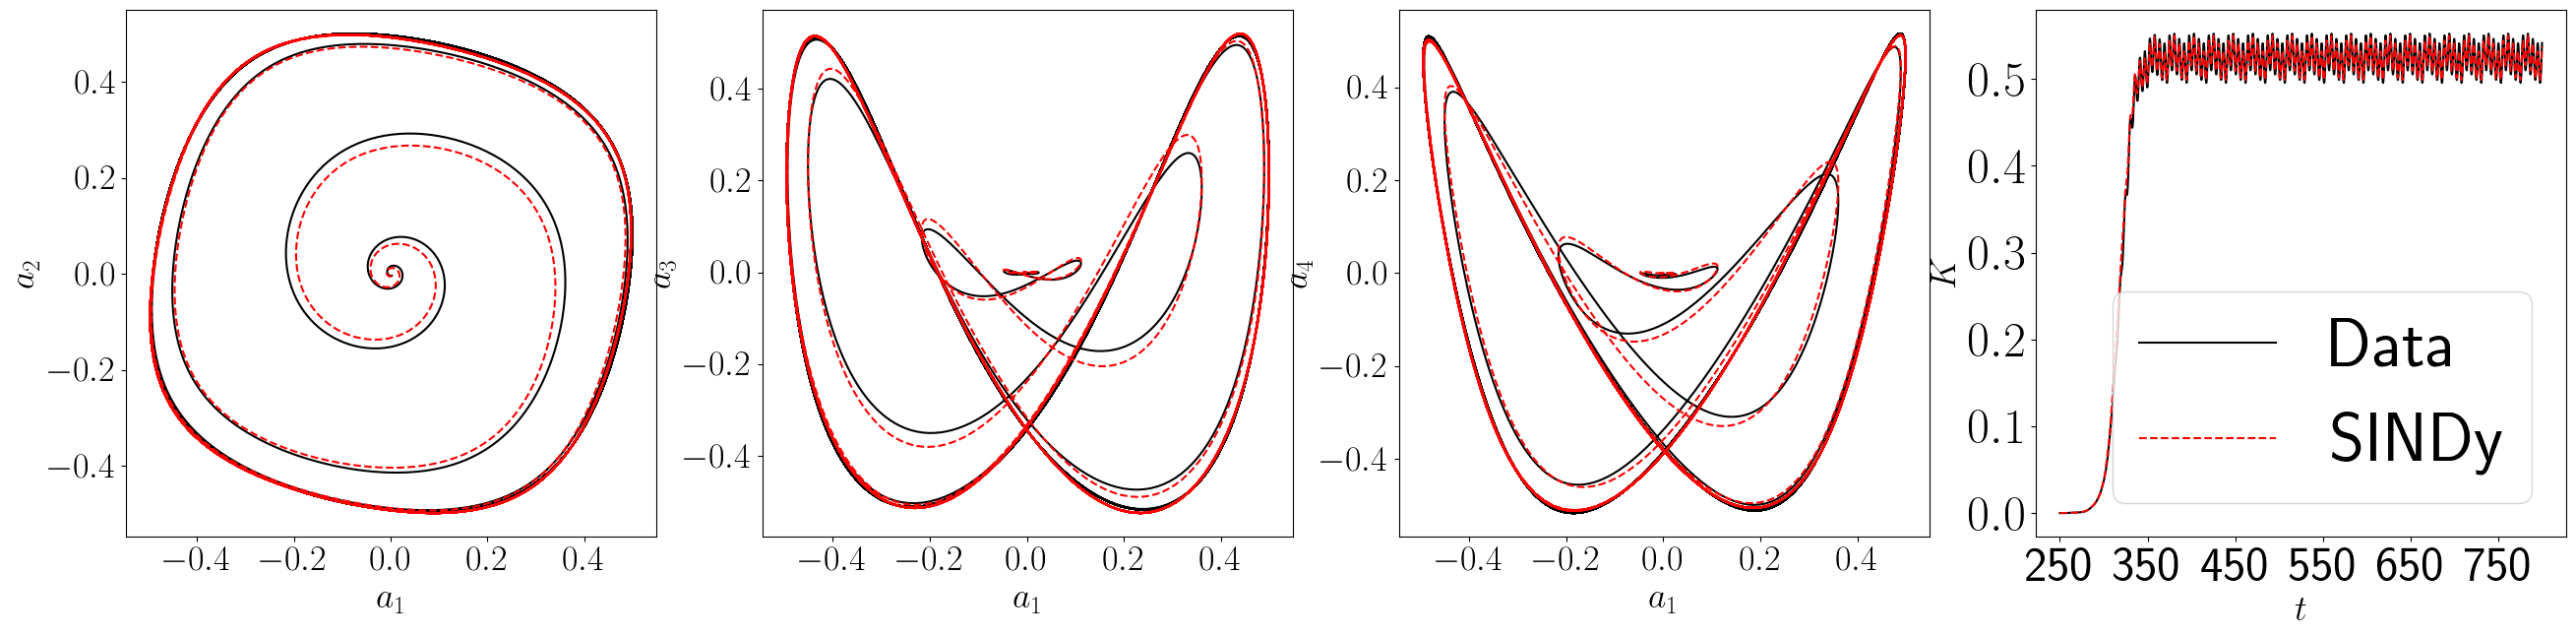

In [19]:
fig = plt.figure(figsize=(32,32))
plt.rcParams['text.usetex'] = True
ax = fig.add_subplot(441)
plt.plot(Avh[:,0]/normalization,Avh[:,1]/normalization,'black',label="Data")
plt.plot(x_sim[:,0],x_sim[:,1],'r--',label="SINDy")
plt.xlabel('$a_1$', fontsize=26)
plt.ylabel('$a_2$', fontsize=26)
plt.yticks(fontsize=26)
plt.xticks(fontsize=26)

#plt.xticks([])
#plt.yticks([])

#plt.legend()

ax = fig.add_subplot(442)
plt.plot(Avh[:,0]/normalization,Avh[:,2]/normalization,'black',label="Data")
plt.plot(a0[:],a2[:],'r--',label="SINDy")#plt.xticks([])
#plt.yticks([])
plt.xlabel('$a_1$', fontsize=26)
plt.ylabel('$a_3$', fontsize=26)
plt.yticks(fontsize=26)
plt.xticks(fontsize=26)

#plt.legend(fontsize=16)

ax = fig.add_subplot(443)
plt.plot(Avh[:,0]/normalization,Avh[:,3]/normalization,'black',label="Data")
plt.plot(a0[:],a3[:],'r--',label="SINDy")#plt.xticks([])
#plt.yticks([])
plt.xlabel('$a_1$', fontsize=26)
plt.ylabel('$a_4$', fontsize=26)
plt.yticks(fontsize=26)
plt.xticks(fontsize=26)

kin_energy = (Avh[:, 0] / normalization)*(Avh[:, 0] / normalization) + (Avh[:, 1] / normalization)*(Avh[:, 1] / normalization) + (Avh[:, 2] / normalization)*(Avh[:, 2] / normalization)+ (Avh[:, 3] / normalization)*(Avh[:, 3] / normalization)
kin_energy_sindy = a0[:]*a0[:] + a1[:]*a1[:]+ a2[:]*a2[:]+ a3[:]*a3[:]


ax = fig.add_subplot(444)
plt.plot(kin_energy,'black',label="Data")
plt.plot(kin_energy_sindy,'r--',label="SINDy")
plt.xlabel(r'$t$',fontsize=26)
plt.ylabel(r'$K$',fontsize=26)
plt.legend(fontsize=30)
ax = plt.gca()
rescale_fat = 0.1
res_shift = 250
rescale_ticks(ax, rescale_fat,res_shift)
plt.yticks(fontsize=36)
plt.xticks(fontsize=36)
plt.legend(fontsize=50)

In [20]:
# Next, we reconstruct the fields from the predicted modes
Tnn =  Tn[:,:5500] 
a2 = a2[:5500]
a3 = a3[:5500]
a2 = a2*normalization
a3 = a3*normalization


In [21]:
a2 = a2.reshape((5500,-1)) 
a3 = a3.reshape((5500,-1)) 


In [22]:
x_sim_norm = x_sim*normalization
x_sim_norm = np.concatenate([x_sim_norm, a2, a3],1)


In [23]:
# reconstruction DATA for a fixed snapshot
# Trace of A (subtracted data)
Tn1 = Tn[:,5499].reshape((Tr.shape[0],Tr.shape[1],3)) 
trace_A = (Tn1[:,:,0]*Tn1[:,:,0])+(Tn1[:,:,2]*Tn1[:,:,2])+(2*(Tn1[:,:,1]*Tn1[:,:,1]))


In [24]:
# reconstruction SINDy
phii  = Tnn@Q[:,:]@E[:,:] # constructing the spatial modes from Method of snapshots
Er = E[:4,:4] # first r components of diagonal matrix E
Sigmar = Sigma[:4,:4] # first r components
Xsindy = phii[:,:4]@Sigmar@x_sim_norm.T
Xsindy1 = Xsindy[:,5499].reshape((Tr.shape[0],Tr.shape[1],3)) 
trace_A_SINDy = (Xsindy1[:,:,0]*Xsindy1[:,:,0])+(Xsindy1[:,:,2]*Xsindy1[:,:,2])+(2*(Xsindy1[:,:,1]*Xsindy1[:,:,1]))
# computing the error
error = np.abs(trace_A-trace_A_SINDy)/np.linalg.norm(trace_A)
error1 = np.abs(Tn1[:,:,0]-Xsindy1[:,:,0])/np.linalg.norm(Tn1[:,:,0])
error2 = np.abs(Tn1[:,:,1]-Xsindy1[:,:,1])/np.linalg.norm(Tn1[:,:,1])
error3 = np.abs(Tn1[:,:,2]-Xsindy1[:,:,2])/np.linalg.norm(Tn1[:,:,2])


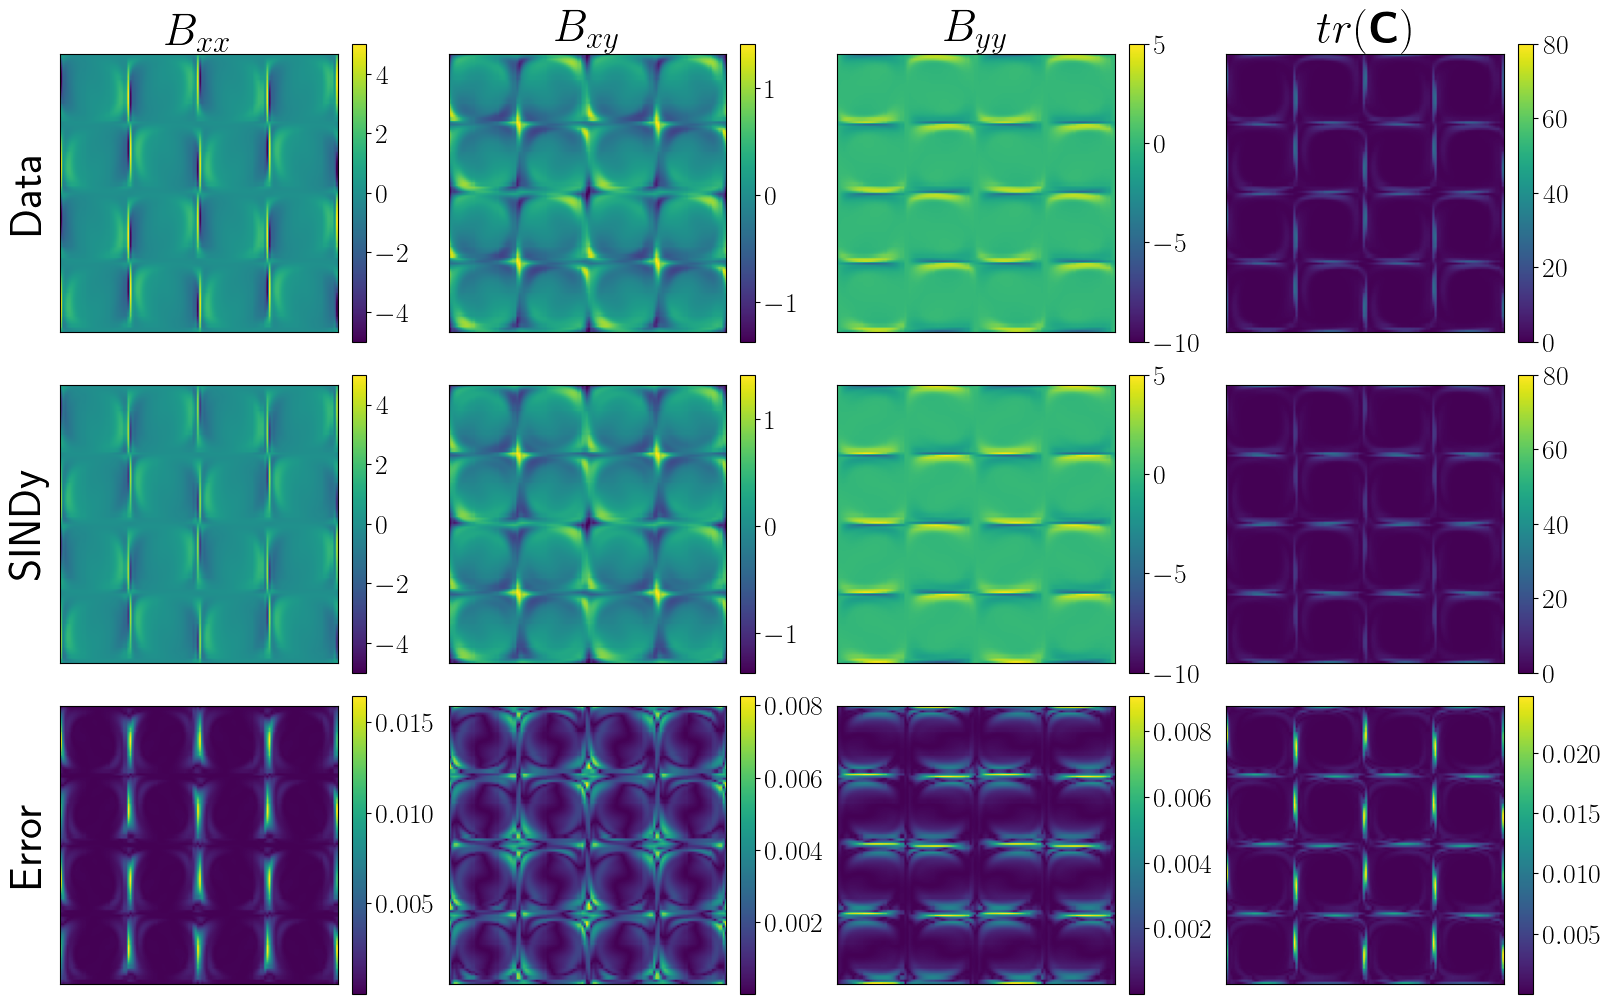

In [25]:
fig = plt.figure(figsize=(16,10),constrained_layout=True)
plt.rcParams['text.usetex'] = True
ax = plt.subplot2grid((3,4), (0,0), rowspan=1, colspan=1)
surf = ax.imshow(Tn1[:,:,0])
#plt.colorbar(surf)
plt.title('$B_{xx}$',fontsize=32)
plt.ylabel(r'Data',fontsize=32)
plt.xticks([])
plt.yticks([])
surf.set_clim(-5,5)
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (0,1), rowspan=1, colspan=1)
surf = ax.imshow(Tn1[:,:,1])
#plt.colorbar(surf)
plt.title('$B_{xy}$',fontsize=32)
plt.xticks([])
plt.yticks([])
#surf.set_clim(-1.5,1.5)
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (0,2), rowspan=1, colspan=1)
surf = ax.imshow(Tn1[:,:,2])
#plt.colorbar(surf)
plt.title('$B_{yy}$',fontsize=32)
plt.xticks([])
plt.yticks([])
surf.set_clim(-10,5)
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (0,3), rowspan=1, colspan=1)
surf = ax.imshow(trace_A)
plt.title(r'$tr(\textbf{C})$',fontsize=32)
#plt.xlabel('snapshots')
plt.xticks([])
plt.yticks([])
surf.set_clim(0,80)
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (1,0), rowspan=1, colspan=1)
surf = ax.imshow(Xsindy1[:,:,0])
#plt.colorbar(surf)
#plt.title('$B_{xx}$')
plt.ylabel(r'SINDy',fontsize=32)
plt.xticks([])
plt.yticks([])
surf.set_clim(-5,5)
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)


ax = plt.subplot2grid((3,4), (1,1), rowspan=1, colspan=1)
surf = ax.imshow(Xsindy1[:,:,1])
#plt.colorbar(surf)
#plt.title('$B_{xy}$')
plt.xticks([])
plt.yticks([])
#surf.set_clim(-1.5,1.5)
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (1,2), rowspan=1, colspan=1)
surf = ax.imshow(Xsindy1[:,:,2])
#plt.colorbar(surf)
#plt.title('$B_{yy}$')
plt.xticks([])
plt.yticks([])
surf.set_clim(-10,5)
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (1,3), rowspan=1, colspan=1)
surf = ax.imshow(trace_A_SINDy)
#plt.title(r'$a_2$',fontsize=22)
#plt.xlabel('snapshots')
plt.xticks([])
plt.yticks([])
surf.set_clim(0,80)
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)


ax = plt.subplot2grid((3,4), (2,0), rowspan=1, colspan=1)
surf = ax.imshow(error1)
#plt.colorbar(surf)
#plt.title('$B_{xx}$')
plt.ylabel(r'Error',fontsize=32)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)


ax = plt.subplot2grid((3,4), (2,1), rowspan=1, colspan=1)
surf = ax.imshow(error2)
#plt.colorbar(surf)
#plt.title('$B_{xy}$')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (2,2), rowspan=1, colspan=1)
surf = ax.imshow(error3)
#plt.colorbar(surf)
#plt.title('$B_{yy}$')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

ax = plt.subplot2grid((3,4), (2,3), rowspan=1, colspan=1)
surf = ax.imshow(error)
#plt.title(r'$a_3$',fontsize=22)
#plt.xlabel('snapshots')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(surf)
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)
